# Text Classification on Hacker News Data

Hacker News is a social news website focusing on computer science and entrepreneurship. It is run by Paul Graham's investment fund and startup incubator, Y Combinator. In general, content that can be submitted is defined as "anything that gratifies one's intellectual curiosity".  

This dataset contains all stories and comments from Hacker News from its launch in 2006. Each story contains a story id, the author that made the post, when it was written, and the number of points the story received.  
  
The dataset is publicly available on Google Cloud BigQuery in `bigquery-public-data` project. **We will look at the titles of articles and figure out whether the article came from the New York Times, TechCrunch or GitHub.**

## Data Preparation

In [ ]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import sys
sys.path.append('./utils')

from common_functions import plot_curves

print(tf.__version__)

2.9.1


In [ ]:
traindf = pd.read_csv('data/hackernews-train.csv')
evaldf = pd.read_csv('data/hackernews-eval.csv')

print(traindf.shape, evaldf.shape)

(72162, 2) (24041, 2)


In [ ]:
print(traindf['source'].unique())
print(traindf.head(1))

['github' 'nytimes' 'techcrunch']
   source                                            title
0  github  this guy just found out how to bypass adblocker


In [ ]:
CLASSES = {'github' : 0, 'nytimes' : 1, 'techcrunch' : 2}

traindf['source'] = traindf['source'].apply(lambda x: CLASSES[x])
evaldf['source'] = evaldf['source'].apply(lambda x: CLASSES[x])
print(traindf['source'].unique())

ytrain = keras.utils.to_categorical(traindf.pop('source').values)
yvalid = keras.utils.to_categorical(evaldf.pop('source').values)
print(ytrain[0])

texts = list(traindf['title'])

[0 1 2]
[1. 0. 0.]


<AxesSubplot:>

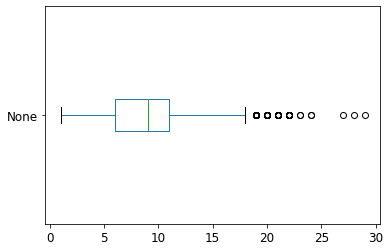

In [ ]:
tokens = [text.split(' ') for text in texts]
seq_len = pd.Series([len(x) for x in tokens])
seq_len.plot.box(vert=False)

In [ ]:
print(sorted(tokens, key=lambda x: len(x))[:25])

[['rails-debate'], ['fpmltoolkit.net'], ['linuxexplorer'], ['cameroncode'], ['zsh-autosuggestions'], ['explosion.js'], ['om-autocomplete'], ['webpack-howto'], ['webtorrents'], ['awesome-advent'], ['google-places-api-java'], ['horse-hackernews'], ['autopolyfiller.js'], ['gitnodeploy'], ['react-motion'], ['s3concurrent'], ['hosts-google-facebook-twitter'], ['open-transactions'], ['underscore.string.js'], ['underscore.lua'], ['docco.coffee'], ['browserify-loader'], ['heroku.json'], ['comcastifyjs'], ['boycottopera.js']]


In [ ]:
texts = [text for (text, textlen) in zip(texts, [len(x) for x in texts]) if textlen > 1]

We want to use only TOP_K words for classification to keep only informative text and be memory-efficient still. `Tokenizer` would still build the word-index for all words, but will only use TOP_K indexes during transformations.

In [ ]:
TOP_K = 20000

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=TOP_K,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=None,
    analyzer=None,
)

tokenizer.fit_on_texts(texts)
Xtrain = tokenizer.texts_to_sequences(texts)
Xvalid = tokenizer.texts_to_sequences(list(evaldf['title']))

assert len(Xtrain) == traindf.shape[0]

In [ ]:
sample = texts[:1]
seq = tokenizer.texts_to_sequences(sample)
txt = tokenizer.sequences_to_texts(seq)

print(f"{txt}:{seq}")

['this guy just found out how to bypass']:[[103, 1549, 122, 646, 72, 26, 3, 3704]]


In [ ]:
MAX_LEN = 20

Xtrain = tf.keras.preprocessing.sequence.pad_sequences(
    sequences=Xtrain,
    maxlen=MAX_LEN,
    padding="pre",
    truncating="pre")

Xvalid = tf.keras.preprocessing.sequence.pad_sequences(
    sequences=Xvalid,
    maxlen=MAX_LEN,
    padding="pre",
    truncating="pre")

assert set([MAX_LEN]) == set([len(x) for x in Xtrain])

### Load pre-trained (GloVe) embeddings

In [ ]:
embeddings_all = {}
with open('./data/glove.6B.200d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_all[word] = coefs

In [ ]:
# We only want embeddings for known words
embedding_dim = 200

num_words = min(len(tokenizer.word_index) + 1, TOP_K)
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in tokenizer.word_index.items():
    # Since the tokenizer already creates index based on word-frequency,
    # we're sure to find most occuring words in TOP_K
    if i >= TOP_K:
        continue
    embedding_vector = embeddings_all.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


## Model

In [ ]:
%%time
keras.backend.clear_session()

save_model = True
use_pretrained_embedding = True
is_embedding_trainable = False
filters = 64
dropout_rate = 0.2
kernel_size = 3
pool_size = 3


model = keras.models.Sequential()

model.add(keras.layers.InputLayer(input_shape=(MAX_LEN,)))

if not use_pretrained_embedding:
    model.add(keras.layers.Embedding(
        input_dim=TOP_K,
        output_dim=embedding_dim,
        embeddings_initializer='uniform',
    ))
else:
    model.add(keras.layers.Embedding(
        input_dim=TOP_K,
        output_dim=embedding_dim,
        input_length=MAX_LEN,
        weights=[embedding_matrix],
        trainable=is_embedding_trainable
    ))

model.add(keras.layers.Dropout(rate=dropout_rate))
model.add(keras.layers.Conv1D(
    filters=filters,
    kernel_size=kernel_size,
    activation="relu",
    padding="same"
))

model.add(keras.layers.MaxPool1D(pool_size=pool_size))
model.add(keras.layers.Conv1D(
    filters=filters * 2,
    kernel_size=kernel_size,
    activation="relu",
    padding="same"
))

model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dropout(rate=dropout_rate))
model.add(keras.layers.Dense(units=len(CLASSES), activation="softmax"))

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy",]
)

history = model.fit(
    x=Xtrain,
    y=ytrain,
    batch_size=20000,
    epochs=5,
    verbose=1,
    validation_data=(Xvalid, yvalid),
    shuffle=True,
)

if save_model:
    model.save('./model.tf')
    with open('history.txt', 'w') as f:
        f.write(json.dumps(history.history))

model.summary()

Epoch 1/5
4/4 [==============================] - 14s 3s/step - loss: 1.0724 - accuracy: 0.4250 - val_loss: 1.0104 - val_accuracy: 0.5823
Epoch 2/5
4/4 [==============================] - 14s 3s/step - loss: 0.9772 - accuracy: 0.5978 - val_loss: 0.8984 - val_accuracy: 0.6748
Epoch 3/5
4/4 [==============================] - 15s 3s/step - loss: 0.8622 - accuracy: 0.6530 - val_loss: 0.7798 - val_accuracy: 0.7010
Epoch 4/5
4/4 [==============================] - 14s 3s/step - loss: 0.7582 - accuracy: 0.6858 - val_loss: 0.6991 - val_accuracy: 0.7137
Epoch 5/5
4/4 [==============================] - 14s 3s/step - loss: 0.6973 - accuracy: 0.7025 - val_loss: 0.6574 - val_accuracy: 0.7230
INFO:tensorflow:Assets written to: ./model.tf/assets
INFO:tensorflow:Assets written to: ./model.tf/assets
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 200)           40

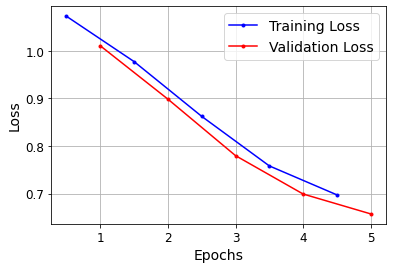

In [ ]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss')

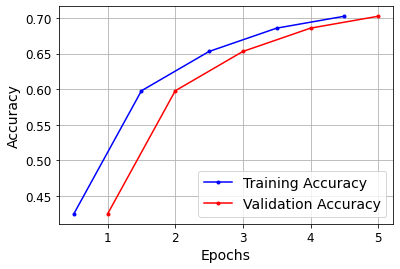

In [ ]:
plot_curves(history.history['accuracy'],
            history.history['accuracy'],
            label='Accuracy')

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(Xvalid)
one_hot_pred = keras.utils.to_categorical(np.argmax(y_pred, axis=1))
print(classification_report(yvalid, one_hot_pred))

752/752 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      9080
           1       0.62      0.68      0.65      7201
           2       0.70      0.61      0.65      7760

   micro avg       0.72      0.72      0.72     24041
   macro avg       0.72      0.71      0.71     24041
weighted avg       0.72      0.72      0.72     24041
 samples avg       0.72      0.72      0.72     24041



In [ ]:
from sklearn.metrics import confusion_matrix

labels = list(CLASSES)
conf_mat_dict={}

for label_col in range(len(labels)):
    y_true_label = yvalid[:, label_col]
    y_pred_label = one_hot_pred[:, label_col]
    conf_mat_dict[labels[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)

for label, matrix in conf_mat_dict.items():
    print("Confusion matrix for label {}:".format(label))
    print(matrix)

Confusion matrix for label github:
[[13330  1631]
 [ 1354  7726]]
Confusion matrix for label nytimes:
[[13835  3005]
 [ 2306  4895]]
Confusion matrix for label techcrunch:
[[14258  2023]
 [ 2999  4761]]


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=46e3e238-14db-4736-bba3-428176481d68' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>